In [1]:
# Libraries 
import torch
from torch.nn import functional as F
from datasets import load_dataset
import os
import pickle
import random
from tokenizer import RegExpTokenizer
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel
random.seed(1330) 

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # what is the maximum context length for predictions
n_embd = 384
n_head = 6
dropout = 0.2
ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])
vocab_size = 1000
tokenizer = RegExpTokenizer()
tokens = tokenizer.encode(haikutext, vocab_size, verbose=False)



In [8]:
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)
model.load_state_dict(torch.load(f'./model_weightsRegexToken/model_weights_22100.pth', weights_only=True))
m = model.to(device)

In [10]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
Haikus =  tokenizer.decode(model.generate(context, max_new_tokens=1000)[0].tolist())
print(Haikus)

 he daughter strangers. / Kind of slanks and sings.
The world is unright. / Haiku therapy. / Taste of anama.
Mirror, envy dewgs. / Where ait spells lied?
My dog kayoffs to. / Those who am I still alive. / An accidental legs.
Near of refuseddit. / The water dust. / The lingering sun.
Rivering heat. / My air turns clapped. / On the cashiernewbe.
A dark chains collect. / On Christmas standard. / Hurry.
Bult of Aard. / Drimy hand on my face.
Sweet wintery. / Evide. / My heart boxes, catches a mxsport.
Another stood. / In Towiti if noticer. / Looks wrapped at work.
The words are shower. / Early flated the sky. / All that will lack of life.
Afternoon took. / The nurse vibes not open.
The ashwords of the rain. / I don't forget.
Steak and cold. / Coaching of fridge. / The sound of winter. / Truck ones.
I look up to friends. / Women we were mah. / Moments yet great acts.
I change how much. / I have a quarrow enough dewe. / Everything vious shatter.
Crystals shroudly whispers. / Trouble, on infl

In [12]:
import nltk
from nltk.corpus import words
import re

# Download the words corpus (if you haven't already)
nltk.download('words')

# Get the list of valid English words from nltk corpus
valid_words = set(words.words())

def percentage_real_words(input_string):
    # Remove non-alphabetic characters and split the string into words
    word_list = re.findall(r'\b[a-zA-Z]+\b', input_string)
    
    # Count the real words
    real_word_count = sum(1 for word in word_list if word.lower() in valid_words)
    
    # Calculate the percentage of real words
    if len(word_list) == 0:
        return 0  # To avoid division by zero
    return (real_word_count / len(word_list)) * 100

# Example usage
tenKtest = tokenizer.decode(model.generate(context, max_new_tokens=10000)[0].tolist())
real_word_percentage = percentage_real_words(tenKtest)
print(f"Percentage of real words: {real_word_percentage:.2f}%")

[nltk_data] Downloading package words to
[nltk_data]     /Users/clayolsen1/nltk_data...
[nltk_data]   Package words is already up-to-date!


Percentage of real words: 84.82%


# Checking the Syllable counts for the 3 lines of Haiku


In [14]:
#Functions for counting syllables in each section using Pyphen as vowel seperating using regular expression is qutie unreliable

import pyphen

# Initialize pyphen for English syllable splitting
dic = pyphen.Pyphen(lang='en')

# Function to count syllables in a sentence using pyphen
def count_syllables(sentence):
    words = sentence.split()
    syllable_count = 0
    for word in words:
        # Use pyphen to split word into syllables
        syllables = dic.inserted(word)
        syllable_count += syllables.count('-') + 1  # Count the number of syllables
    return syllable_count

# Function to process the string and count syllables for each sentence position
def count_syllables_in_lines(text):
    # Split text into lines
    lines = text.strip().split('\n')
    
    # Initialize counters for syllables in each sentence position
    first_sentence_syllables = []
    second_sentence_syllables = []
    third_sentence_syllables = []
    
    # Process each line
    for line in lines:
        # Split the line into sentences based on " / " separator
        sentences = re.split(r'[\.,!?]?\s*/\s*', line)
        
        # Track syllables for each sentence position
        if len(sentences) >= 3:
            first_sentence_syllables.append(count_syllables(sentences[0]))
            second_sentence_syllables.append(count_syllables(sentences[1]))
            third_sentence_syllables.append(count_syllables(sentences[2]))
    
    return first_sentence_syllables, second_sentence_syllables, third_sentence_syllables

In [16]:
#Now for Training Data
input_text = haikutext[0:10000]

# Run the function on the input text
first_syllablesTrain, second_syllablesTrain, third_syllablesTrain = count_syllables_in_lines(input_text)
#Last sentences are probably cutoff midway
first_syllablesTrain, second_syllablesTrain, third_syllablesTrain = first_syllablesTrain[:-1], second_syllablesTrain[:-1], third_syllablesTrain[:-1]
# Output the results
print(f"First sentences syllable counts: {first_syllablesTrain}")
print(f"Second sentences syllable counts: {second_syllablesTrain}")
print(f"Third sentences syllable counts: {third_syllablesTrain}")

First sentences syllable counts: [5, 5, 3, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 6, 4, 4, 5, 4, 4, 5, 4, 5, 4, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 6, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 5, 3, 4, 4, 3, 5, 4, 3, 4, 5, 4, 5, 5, 5, 5, 5, 3, 4, 5, 5, 3, 3, 5, 4, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 4, 5, 4]
Second sentences syllable counts: [6, 6, 7, 6, 7, 6, 7, 7, 7, 5, 6, 7, 5, 5, 6, 6, 7, 5, 7, 6, 6, 4, 5, 7, 5, 7, 6, 5, 8, 7, 6, 7, 7, 7, 6, 7, 6, 7, 7, 5, 7, 6, 6, 6, 7, 7, 6, 6, 7, 6, 5, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 8, 6, 5, 7, 7, 6, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 6, 5, 5, 6, 7, 7, 6, 7, 7, 6, 8, 6, 7, 7, 7, 7, 6, 7, 6, 7, 7, 7, 6, 6, 6, 7]
Third sentences syllable counts: [5, 5, 5, 5, 5, 4, 6, 5, 4, 5, 4, 5, 5, 5, 4, 5, 5, 5, 6, 5, 4, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 5, 

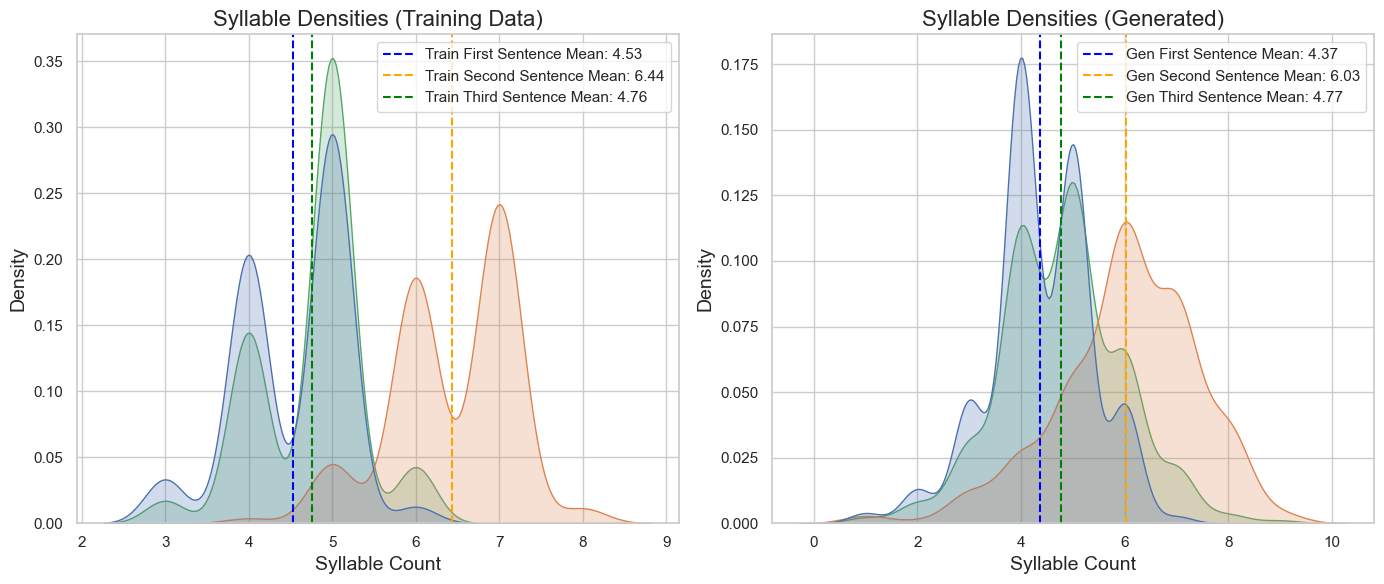

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Create a DataFrame to hold all the syllable data
dataGenerated = pd.DataFrame({
    'Syllables': first_syllables + second_syllables + third_syllables,
    'Sentence Position': ['First'] * len(first_syllables) + 
                         ['Second'] * len(second_syllables) + 
                         ['Third'] * len(third_syllables)
})

dataTraining = pd.DataFrame({
    'Syllables': first_syllablesTrain + second_syllablesTrain + third_syllablesTrain,
    'Sentence Position': ['First'] * len(first_syllablesTrain) + 
                         ['Second'] * len(second_syllablesTrain) + 
                         ['Third'] * len(third_syllablesTrain)
})

# Calculate means
mean_first = np.mean(first_syllables)
mean_second = np.mean(second_syllables)
mean_third = np.mean(third_syllables)

# Set the style for seaborn
sns.set(style="whitegrid")

# Calculate means
mean_firstTrain = np.mean(first_syllablesTrain)
mean_secondTrain = np.mean(second_syllablesTrain)
mean_thirdTrain = np.mean(third_syllablesTrain)


# Set up the figure and the subplots (2 plots side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set the style for seaborn
sns.set(style="whitegrid")

# First subplot (on the left)
sns.kdeplot(data=dataTraining, x='Syllables', hue='Sentence Position', fill=True, ax=axes[0])

# Add vertical lines for the means (dotted lines) in the first plot
axes[0].axvline(mean_firstTrain, color='blue', linestyle='--', label=f'Train First Sentence Mean: {mean_firstTrain:.2f}')
axes[0].axvline(mean_secondTrain, color='orange', linestyle='--', label=f'Train Second Sentence Mean: {mean_secondTrain:.2f}')
axes[0].axvline(mean_thirdTrain, color='green', linestyle='--', label=f'Train Third Sentence Mean: {mean_thirdTrain:.2f}')
axes[0].set_title('Syllable Densities (Training Data)', fontsize=16)
axes[0].set_xlabel('Syllable Count', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].legend()

# Second subplot (on the right, copy of the first)
sns.kdeplot(data=dataGenerated, x='Syllables', hue='Sentence Position', fill=True, ax=axes[1])

# Add vertical lines for the means (dotted lines) in the second plot
axes[1].axvline(mean_first, color='blue', linestyle='--', label=f'Gen First Sentence Mean: {mean_first:.2f}')
axes[1].axvline(mean_second, color='orange', linestyle='--', label=f'Gen Second Sentence Mean: {mean_second:.2f}')
axes[1].axvline(mean_third, color='green', linestyle='--', label=f'Gen Third Sentence Mean: {mean_third:.2f}')
axes[1].set_title('Syllable Densities (Generated)', fontsize=16)
axes[1].set_xlabel('Syllable Count', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
